# Cats and Dogs classification
Aqui vamos implementar uma rede neural simples em Keras para classificar gatos e cachorros. A idéias desse problema é se adaptar a linguagem e implementação do Keras, assim como a utilizar redes neurais convolucionais.

referencias:

https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html

https://medium.com/@parthvadhadiya424/hello-world-program-in-keras-with-cnn-dog-vs-cat-classification-efc6f0da3cc5

### Importing LIbraries

In [1]:
import os
import sys
import random
import warnings

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

from tqdm import tqdm
from itertools import chain
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label

from tensorflow import keras

warnings.filterwarnings('ignore', category=UserWarning, module='skimage')
seed = 42

/home/marcelostachuk/anaconda3/lib/python3.6/site-packages/requests/__init__.py:91: RequestsDependencyWarning: urllib3 (1.24) or chardet (3.0.4) doesn't match a supported version!
  RequestsDependencyWarning)


### Pre-processing Image and data augmentation

#### Separando test e train

Como nosso dataset é grande o suficiente não faremos augmentation mas é uma boa testar mais pra frente isso

Temos que separar em duas pastas as imagens para train e para test. Isto foi feito em bash
(25% para teste e 75% para treino de 12500 images de cada instancia)

#### Gerando o conjunto de treino

In [68]:
# Set some parameters
IMG_WIDTH = 128
IMG_HEIGHT = 128
IMG_CHANNELS = 3
TRAIN_PATH_DOG = './dataset/train/dog/'
TRAIN_PATH_CAT = './dataset/train/cat/'
TEST_PATH_DOG = './dataset/test/dog/'
TEST_PATH_CAT = './dataset/test/cat/'

In [69]:
# Get train and test IDs
train_ids_dog = next(os.walk(TRAIN_PATH_DOG))[2]
train_ids_cat = next(os.walk(TRAIN_PATH_CAT))[2]
test_ids_dog = next(os.walk(TEST_PATH_DOG))[2]
test_ids_cat = next(os.walk(TEST_PATH_CAT))[2]

In [4]:
# Get and resize dog train images
X_train_dog = np.zeros((len(train_ids_dog), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
Y_train_dog = np.zeros((len(train_ids_dog), 1), dtype=np.uint8)

print('Getting and resizing dog images ... ')
sys.stdout.flush()
for n, id_ in tqdm(enumerate(train_ids_dog), total=len(train_ids_dog)):
    path = TRAIN_PATH_DOG
    img = imread(path +id_ )[:,:,:IMG_CHANNELS]
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_train_dog[n] = img
    Y_train_dog[n] = 1


Getting and resizing dog images ... 


100%|██████████| 9167/9167 [02:48<00:00, 54.40it/s]


In [5]:
X_train_cat = np.zeros((len(train_ids_cat), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
Y_train_cat = np.zeros((len(train_ids_cat), 1), dtype=np.uint8)

print('Getting and resizing cat images and masks ... ')
sys.stdout.flush()
for n, id_ in tqdm(enumerate(train_ids_cat), total=len(train_ids_cat)):
    path = TRAIN_PATH_CAT
    img = imread(path +id_ )[:,:,:]
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_train_cat[n] = img
    Y_train_cat[n] = 0

Getting and resizing cat images and masks ... 


100%|██████████| 9167/9167 [02:36<00:00, 62.48it/s]


In [9]:
print(X_train_dog[0].shape)

(128, 128, 3)


[1]


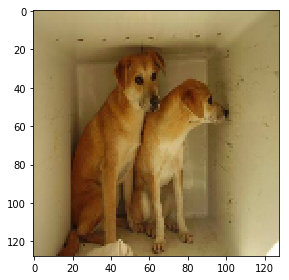

In [10]:
ix = random.randint(0, len(X_train_dog))
imshow(X_train_dog[ix])
print(Y_train_dog[ix])

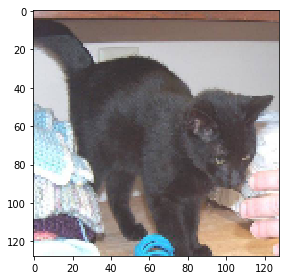

[0]


In [11]:
ix = random.randint(0, len(X_train_cat))
imshow(X_train_cat[ix])
plt.show()
print(Y_train_cat[ix])

In [24]:
#Merging train dataset
X = np.concatenate((X_train_cat, X_train_dog))
y = np.concatenate((Y_train_cat, Y_train_dog))
print(X.shape, y.shape)

(18334, 128, 128, 3) (18334, 1)


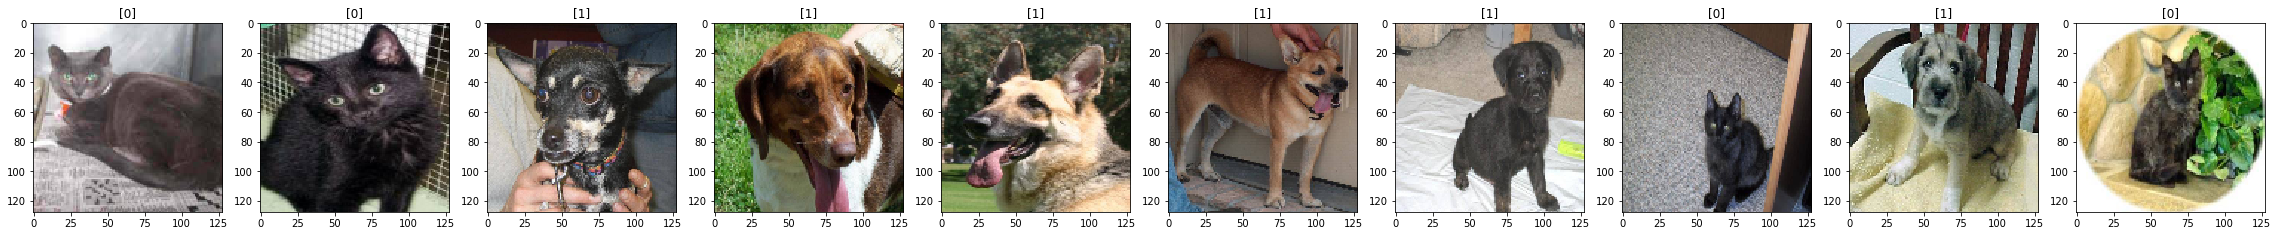

In [25]:
#Verificando consistencia
fig, ax = plt.subplots(1,10, figsize=(40,8))
for i in range(10):
    ix = random.randint(0, len(X))
    ax[i].imshow(X[ix])
    ax[i].set_title(y[ix])

In [26]:
# Fit model
from sklearn import model_selection

X_train, X_val, y_train, y_val = model_selection.train_test_split(X, y, test_size=0.2, random_state=seed)

(14667, 128, 128, 3)


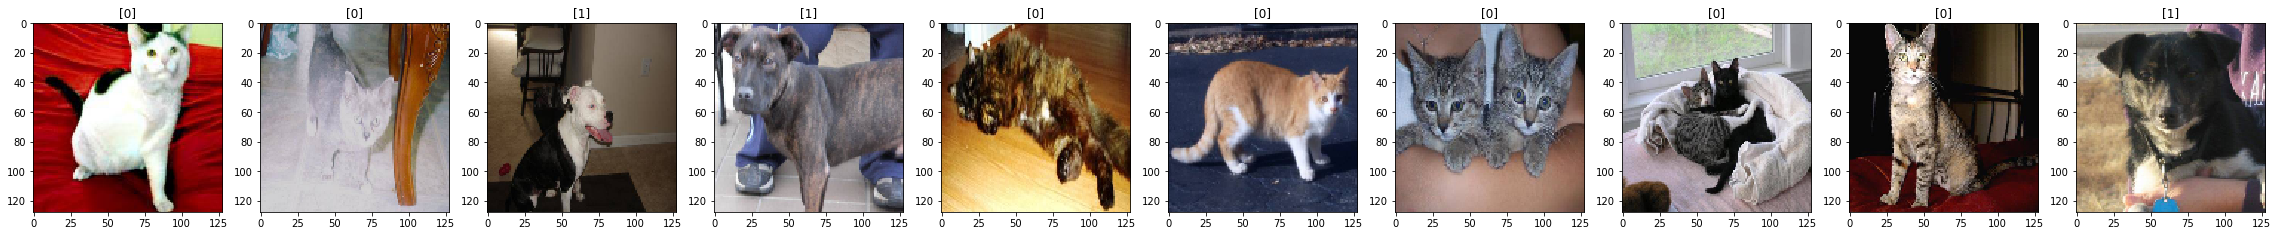

In [27]:
#Check train val split
print(X_train.shape)
#Verificando consistencia
fig, ax = plt.subplots(1,10, figsize=(40,8))
for i in range(10):
    ix = random.randint(0, len(X_train))
    ax[i].imshow(X_train[ix])
    ax[i].set_title(y_train[ix])

(3667, 128, 128, 3)


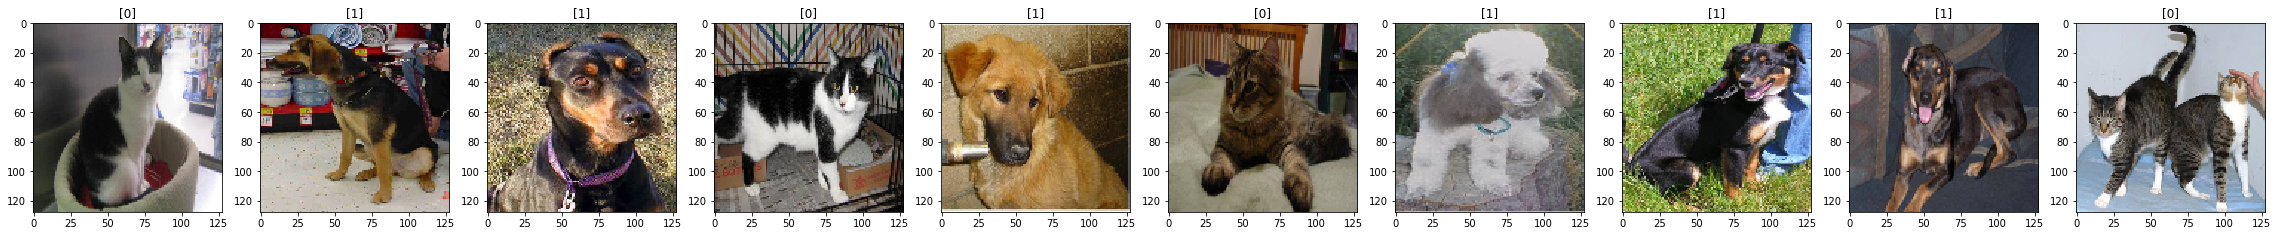

In [28]:
#Check train val split
print(X_val.shape)
#Verificando consistencia
fig, ax = plt.subplots(1,10, figsize=(40,8))
for i in range(10):
    ix = random.randint(0, len(X_val))
    ax[i].imshow(X_val[ix])
    ax[i].set_title(y_val[ix])

### Creating neuralnetwork

Simple neural network

In [29]:
inputs = keras.Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
s = keras.layers.Lambda(lambda x: x / 255) (inputs)

c1 = keras.layers.Conv2D(32, (3,3), activation = 'relu')(inputs)
p1 = keras.layers.MaxPooling2D(pool_size=(2,2))(c1)

c2 = keras.layers.Conv2D(32, (3,3), activation = 'relu')(p1)
p2 = keras.layers.MaxPooling2D(pool_size=(2,2))(c2)

c3 = keras.layers.Conv2D(64, (3,3), activation = 'relu')(p2)
p3 = keras.layers.MaxPooling2D(pool_size=(2,2))(c3)

# this converts our 3D feature maps to 1D feature vectors
f4 = keras.layers.Flatten()(p3)

d5 = keras.layers.Dense(64, activation='relu')(f4)
d5 = keras.layers.Dropout(0.25)(d5)

outputs = keras.layers.Dense(1, activation='sigmoid')(d5)

model = keras.Model(inputs = [inputs], outputs = outputs)
model.compile(loss='binary_crossentropy',
              optimizer=keras.optimizers.Adam(lr=1e-4),
              metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 128, 128, 3)       0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 126, 126, 32)      896       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 61, 61, 32)        9248      
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 30, 30, 32)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 28, 28, 64)        18496     
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 14, 14, 64)        0         
__________

In [30]:
checkpointer = keras.callbacks.ModelCheckpoint('model_first_try.h5', verbose=1, save_best_only=True)

#model = keras.models.load_model('model_first_try.h5')
results = model.fit(X_train, y_train, epochs=50, callbacks=[checkpointer], validation_data=(X_val, y_val))


Train on 14667 samples, validate on 3667 samples
Epoch 1/50
14667/14667 [==============================] - 46s 3ms/step - loss: 0.9576 - acc: 0.5786 - val_loss: 0.6551 - val_acc: 0.5811

Epoch 00001: val_loss improved from inf to 0.65510, saving model to model_first_try.h5
Epoch 2/50
14667/14667 [==============================] - 46s 3ms/step - loss: 0.6250 - acc: 0.6436 - val_loss: 0.6183 - val_acc: 0.6308

Epoch 00002: val_loss improved from 0.65510 to 0.61828, saving model to model_first_try.h5
Epoch 3/50
14667/14667 [==============================] - 45s 3ms/step - loss: 0.5828 - acc: 0.6876 - val_loss: 0.5565 - val_acc: 0.7262

Epoch 00003: val_loss improved from 0.61828 to 0.55651, saving model to model_first_try.h5
Epoch 4/50
14667/14667 [==============================] - 45s 3ms/step - loss: 0.5365 - acc: 0.7279 - val_loss: 0.5639 - val_acc: 0.6978

Epoch 00004: val_loss did not improve from 0.55651
Epoch 5/50
14667/14667 [==============================] - 47s 3ms/step - loss: 


Epoch 00042: val_loss did not improve from 0.42526
Epoch 43/50
14667/14667 [==============================] - 49s 3ms/step - loss: 0.0455 - acc: 0.9802 - val_loss: 1.0247 - val_acc: 0.8077

Epoch 00043: val_loss did not improve from 0.42526
Epoch 44/50
14667/14667 [==============================] - 49s 3ms/step - loss: 0.0463 - acc: 0.9791 - val_loss: 1.1293 - val_acc: 0.7985

Epoch 00044: val_loss did not improve from 0.42526
Epoch 45/50
14667/14667 [==============================] - 50s 3ms/step - loss: 0.0437 - acc: 0.9808 - val_loss: 1.0629 - val_acc: 0.8083

Epoch 00045: val_loss did not improve from 0.42526
Epoch 46/50
14667/14667 [==============================] - 50s 3ms/step - loss: 0.0456 - acc: 0.9807 - val_loss: 1.0968 - val_acc: 0.8007

Epoch 00046: val_loss did not improve from 0.42526
Epoch 47/50
14667/14667 [==============================] - 50s 3ms/step - loss: 0.0400 - acc: 0.9823 - val_loss: 1.0415 - val_acc: 0.8077

Epoch 00047: val_loss did not improve from 0.4252

In [35]:
final_model = keras.models.load_model('model_first_try.h5')

Preparing validation

In [65]:
# Get and resize dog test images
X_test_dog = np.zeros((len(test_ids_dog), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
Y_test_dog = np.zeros((len(test_ids_dog), 1), dtype=np.uint8)

print('Getting and resizing dog images ... ')
sys.stdout.flush()
for n, id_ in tqdm(enumerate(test_ids_dog), total=len(test_ids_dog)):
    path = TEST_PATH_DOG
    img = imread(path +id_ )[:,:,:IMG_CHANNELS]
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_test_dog[n] = img
    Y_test_dog[n] = 1

Getting and resizing dog images ... 


100%|██████████| 3333/3333 [00:30<00:00, 109.37it/s]


In [70]:
# Get and resize cat test images
X_test_cat = np.zeros((len(test_ids_cat), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
Y_test_cat = np.zeros((len(test_ids_cat), 1), dtype=np.uint8)

print('Getting and resizing dog images ... ')
sys.stdout.flush()
for n, id_ in tqdm(enumerate(test_ids_cat), total=len(test_ids_cat)):
    path = TEST_PATH_CAT
    img = imread(path+id_ )[:,:,:IMG_CHANNELS]
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_test_cat[n] = img
    Y_test_cat[n] = 0

Getting and resizing dog images ... 


100%|██████████| 3333/3333 [00:30<00:00, 108.12it/s]


In [71]:
#Merging train dataset
X_test = np.concatenate((X_test_cat, X_test_dog))
y_test = np.concatenate((Y_test_cat, Y_test_dog))
print(X_test.shape, y_test.shape)

(6666, 128, 128, 3) (6666, 1)


(6666, 128, 128, 3)


/home/marcelostachuk/anaconda3/lib/python3.6/site-packages/matplotlib/text.py:1190: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


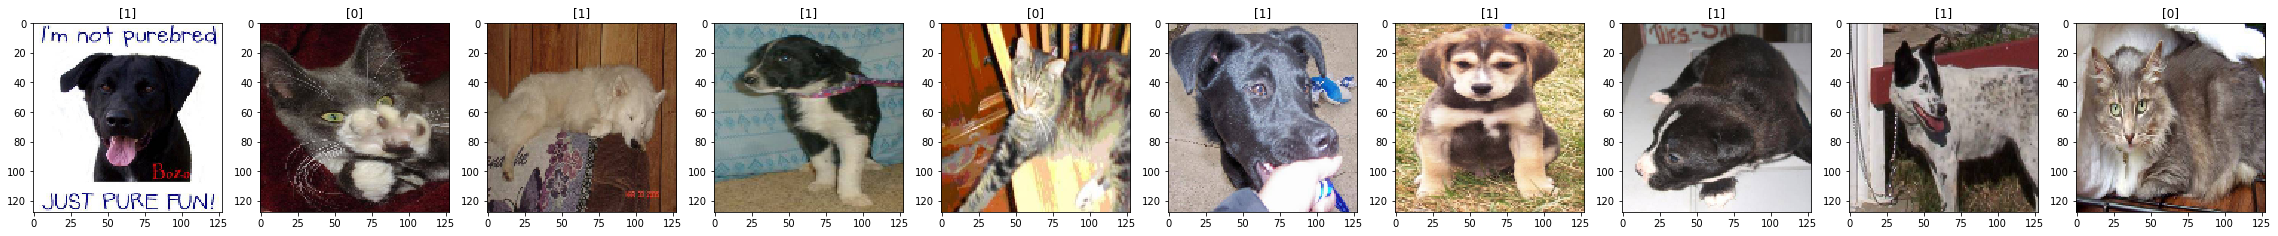

In [72]:
#Check train val split
print(X_test.shape)
#Verificando consistencia
fig, ax = plt.subplots(1,10, figsize=(40,8))
for i in range(10):
    ix = random.randint(0, len(X_test))
    ax[i].imshow(X_test[ix])
    ax[i].set_title(y_test[ix])

Usando no conjunto de teste

In [82]:
y_test_pred = final_model.predict(X_test)

In [88]:
def score(y_pred, y_true):
    score = 0
    for i in range(len(y_true)):
        score += np.abs(np.round(y_pred[i])-y_true[i])
    return 1-score/len(y_test)

print(score(y_test_pred, y_test))

[0.7934294]


Olhando os cachorros e gatos pior classificados

In [243]:
#Probably not the best method
def dogs_wrong(y_pred, y_true):
    dic_where_value = {}
    for i in range(len(y_true)):
        #if is a dog and get wrong
        if (y_true[i] == 1 and np.abs(np.round(y_pred[i])-y_true[i]) != 0):
            dic_where_value[i] = y_pred[i]
    return dic_where_value

def how_many_dogs_wrongs(y_pred, y_true):
    return len(dogs_wrong(y_pred, y_true))

def top_n_wrong_dogs(n, y_pred, y_true):
    dict_wrongs = dogs_wrong(y_pred, y_true)
    if (len(dict_wrongs) <= n):
        return list(dict_wrongs.keys()), list(dict_wrongs.values())
    else:
        all_values = np.sort(np.array(list(dict_wrongs.values())), axis=None)
        #print(all_values.shape)
        top_n_values = all_values[:n]
        #print(top_n_values)
        list_keys = []
        list_values = []
        for i in list(dict_wrongs.keys()):
            if (dict_wrongs[i] in top_n_values):
                list_keys.append(i)
                list_values.append(dict_wrongs[i])
    return list_keys, list_values
                
def print_n_wrong_dogs(n, X_print, y_pred, y_true):
    list_keys, list_values = top_n_wrong_dogs(n, y_pred, y_true)
    fig, ax = plt.subplots(1,n, figsize=(40,8))
    for i in range(n):
        ax[i].imshow(X_print[list_keys[i]])
        ax[i].set_title(str(list_values[i]))
    

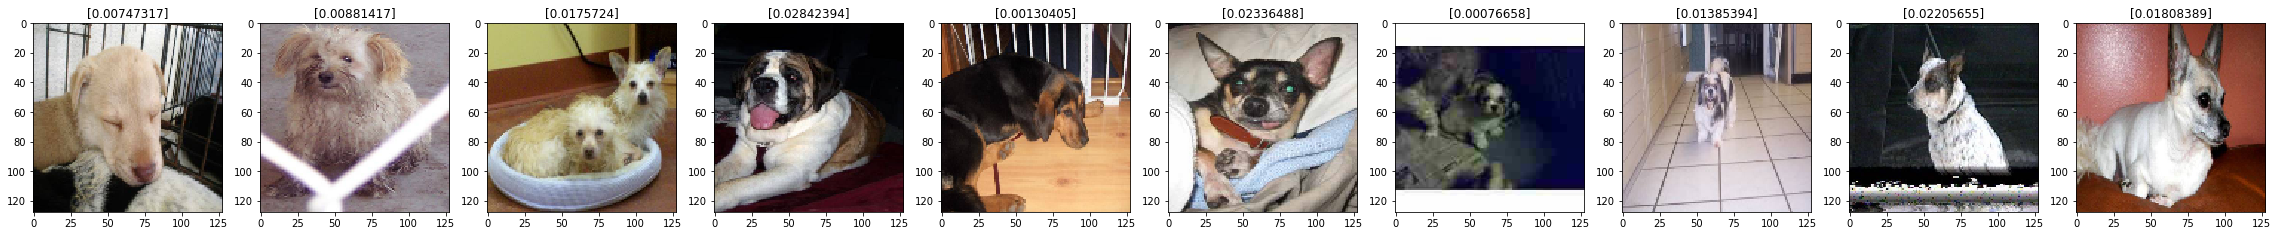

In [191]:
print_n_wrong_dogs(10, X_test, y_test_pred, y_test)

In [242]:
#Probably not the best method
def cats_wrong(y_pred, y_true):
    dic_where_value = {}
    for i in range(len(y_true)):
        #if is a dog and get wrong
        if (y_true[i] == 0 and np.abs(np.round(y_pred[i])-y_true[i]) != 0):
            dic_where_value[i] = y_pred[i]
    return dic_where_value

def how_many_cats_wrongs(y_pred, y_true):
    return len(cats_wrong(y_pred, y_true))

def top_n_wrong_cats(n, y_pred, y_true):
    dict_wrongs = cats_wrong(y_pred, y_true)
    if (len(dict_wrongs) <= n):
        return list(dict_wrongs.keys()), list(dict_wrongs.values())
    else:
        all_values = np.sort(np.array(list(dict_wrongs.values())), axis=None)
        #print(all_values.shape)
        top_n_values = all_values[-n:]
        #print(top_n_values)
        list_keys = []
        list_values = []
        for i in list(dict_wrongs.keys()):
            if (dict_wrongs[i] in top_n_values):
                list_keys.append(i)
                list_values.append(dict_wrongs[i])
    return list_keys, list_values
                
def print_n_wrong_cats(n, X_print, y_pred, y_true):
    list_keys, list_values = top_n_wrong_cats(n, y_pred, y_true)
    fig, ax = plt.subplots(1,n, figsize=(40,8))
    for i in range(n):
        ax[i].imshow(X_print[list_keys[i]])
        ax[i].set_title(str(list_values[i]))
    

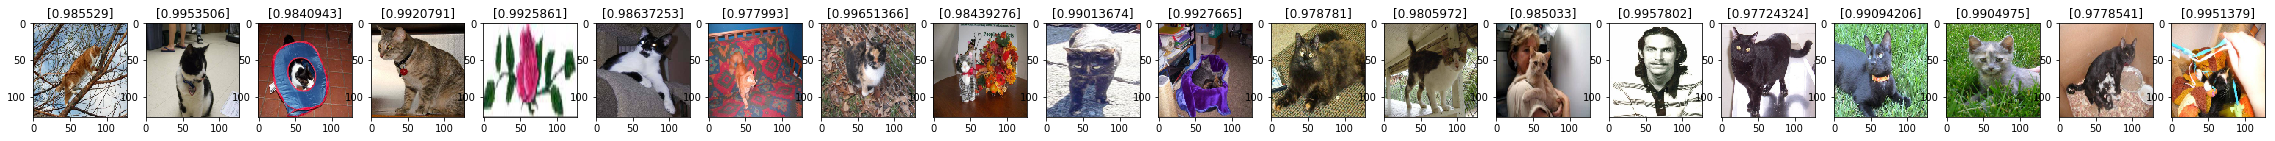

In [197]:
print_n_wrong_cats(20, X_test, y_test_pred, y_test)

## 2 - Usando rede pré treinada

In [204]:
model_vgg = keras.applications.VGG16(include_top=False, weights='imagenet')

bottleneck_features_train = model_vgg.predict(x = X_train)
bottleneck_features_validation = model_vgg.predict(x = X_val)

In [206]:
np.save('bottleneck_features_train.npy', bottleneck_features_train)
np.save('bottleneck_features_validation.npy', bottleneck_features_validation)

In [215]:
bottleneck_features_train.shape[1:]

(4, 4, 512)

In [231]:
train_data = np.load('bottleneck_features_train.npy')
validation_data = np.load('bottleneck_features_validation.npy')


inputs_pre = keras.Input(shape = train_data.shape[1:])

f1_pre = keras.layers.Flatten()(inputs_pre)

d1_pre = keras.layers.Dense(256, activation='relu')(f1_pre)

d2_pre = keras.layers.Dense(64, activation='relu')(d1_pre)
d2_pre = keras.layers.Dropout(0.25)(d2_pre)

outputs = keras.layers.Dense(1, activation='sigmoid')(d2_pre)

model_pre = keras.Model(inputs = [inputs_pre], outputs = outputs)
model_pre.compile(loss='binary_crossentropy',
              optimizer=keras.optimizers.Adam(lr=1e-4),
              metrics=['accuracy'])
model_pre.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_13 (InputLayer)        (None, 4, 4, 512)         0         
_________________________________________________________________
flatten_10 (Flatten)         (None, 8192)              0         
_________________________________________________________________
dense_29 (Dense)             (None, 256)               2097408   
_________________________________________________________________
dense_30 (Dense)             (None, 64)                16448     
_________________________________________________________________
dropout_11 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_31 (Dense)             (None, 1)                 65        
Total params: 2,113,921
Trainable params: 2,113,921
Non-trainable params: 0
_________________________________________________________________


In [236]:
checkpointer_pre = keras.callbacks.ModelCheckpoint('model_second_try.h5', verbose=1, save_best_only=True)

#model = keras.models.load_model('model_first_try.h5')
results_pre = model_pre.fit(train_data, y_train, epochs=25, callbacks=[checkpointer_pre], 
                            validation_data=(validation_data, y_val))

Train on 14667 samples, validate on 3667 samples
Epoch 1/25
14667/14667 [==============================] - 7s 454us/step - loss: 0.0027 - acc: 0.9994 - val_loss: 0.5051 - val_acc: 0.9506

Epoch 00001: val_loss improved from inf to 0.50510, saving model to model_second_try.h5
Epoch 2/25
14667/14667 [==============================] - 7s 453us/step - loss: 0.0046 - acc: 0.9990 - val_loss: 0.5077 - val_acc: 0.9441

Epoch 00002: val_loss did not improve from 0.50510
Epoch 3/25
14667/14667 [==============================] - 7s 458us/step - loss: 0.0034 - acc: 0.9995 - val_loss: 0.5021 - val_acc: 0.9476

Epoch 00003: val_loss improved from 0.50510 to 0.50208, saving model to model_second_try.h5
Epoch 4/25
14667/14667 [==============================] - 7s 473us/step - loss: 0.0060 - acc: 0.9989 - val_loss: 0.4964 - val_acc: 0.9416

Epoch 00004: val_loss improved from 0.50208 to 0.49644, saving model to model_second_try.h5
Epoch 5/25
14667/14667 [==============================] - 7s 471us/step 

In [237]:
final_model_pre = keras.models.load_model('model_second_try.h5')

In [238]:
model_vgg = keras.applications.VGG16(include_top=False, weights='imagenet')
bottleneck_features_test = model_vgg.predict(x = X_test)

In [239]:
y_test_pred_pre = final_model_pre.predict(bottleneck_features_test)

In [249]:
print(score(y_test_pred_pre, y_test))

[0.94569457]


177


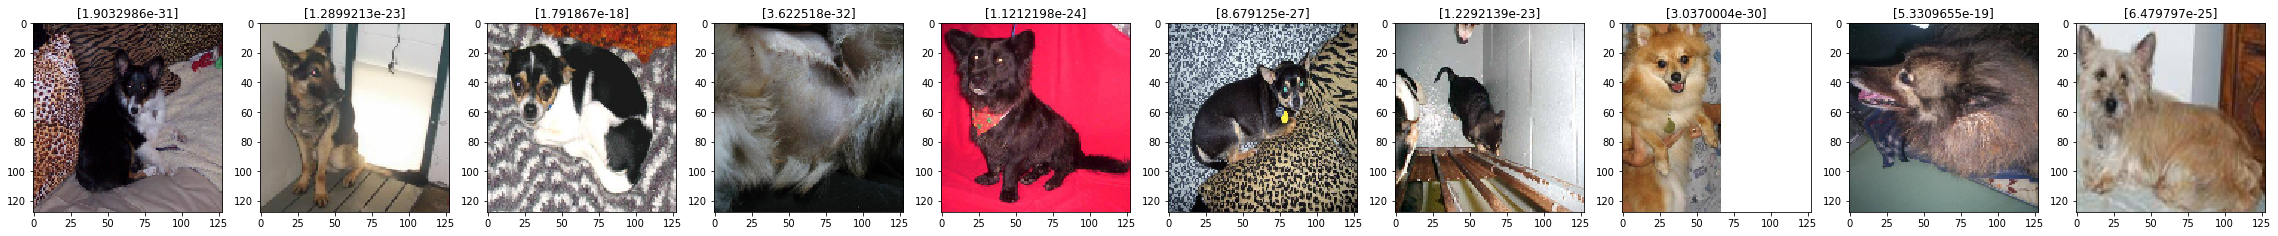

In [245]:
print(how_many_dogs_wrongs(y_test_pred_pre, y_test))
print_n_wrong_dogs(10, X_test, y_test_pred_pre, y_test)

185


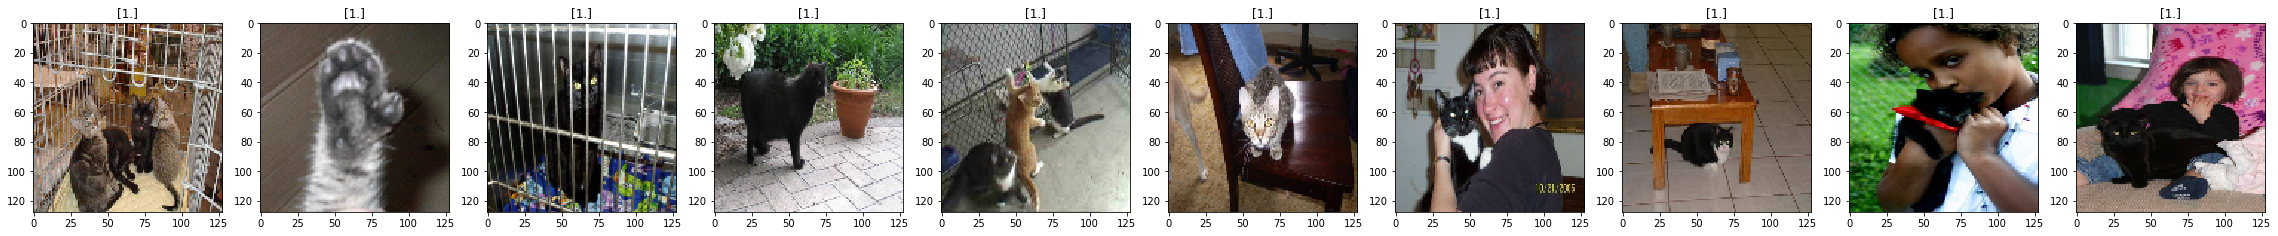

In [246]:
print(how_many_cats_wrongs(y_test_pred_pre, y_test))
print_n_wrong_cats(10, X_test, y_test_pred_pre, y_test)